In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras import optimizers 

from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D, Dropout
from tensorflow.keras import Model

In [ ]:
data_dir = 'input/'
datagen = ImageDataGenerator(rescale=1. / 255)

train = datagen.flow_from_directory(data_dir+'train/', target_size = (299, 299),
                                       batch_size=64)
test = datagen.flow_from_directory(data_dir+'test/', target_size = (299, 299),
                                       batch_size=64)
validator = datagen.flow_from_directory(data_dir+'validation/', target_size = (299, 299),
                                       batch_size=1)

Found 2597 images belonging to 3 classes.
Found 1008 images belonging to 3 classes.
Found 1007 images belonging to 3 classes.


##Define model classifier Xception

In [ ]:
def conv2d(x, filters, kernel, strides=1, use_bias=False):
  x = Conv2D(filters, kernel, strides, use_bias = use_bias, padding="same")(x)               
  x = BatchNormalization()(x)
  return x

def sep_conv(x, filters, kernel, strides=1, use_bias=False):
  x = SeparableConv2D(filters, kernel, strides, use_bias = use_bias, padding="same")(x)
  x = BatchNormalization()(x)
  return x

def xception(input_data):
  #Entry flow
  x = conv2d(input_data, 32, 3, 2, use_bias = False)             
  x = ReLU()(x)
  x = conv2d(x, 64, 3, 2, use_bias = False)  
  residual = ReLU()(x)

  x = sep_conv(x, 128, 3, use_bias = False)  
  x = ReLU()(x)
  x = sep_conv(x, 128, 3, use_bias = False)
  x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)  

  residual = conv2d(residual, 128, 1, 2, use_bias = False)    
  x = Add()([residual,x])

  x = ReLU()(x)
  x = sep_conv(x, 256, 3, use_bias = False)  
  x = ReLU()(x)
  x = sep_conv(x, 256, 3, use_bias = False)  
  x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)  

  residual = conv2d(residual, 256, 1, 2, use_bias = False)
  x = Add()([residual,x])
  
  x = ReLU()(x)  
  x = sep_conv(x, 728, 3, use_bias = False)
  x = ReLU()(x)  
  x = sep_conv(x, 728, 3, use_bias = False)
  x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)  

  residual = conv2d(residual, 728, 1, 2, use_bias = False)  
  x = Add()([residual,x])
  
  
  #Middle flow
  for i in range(8):
    x = ReLU()(x)
    x = sep_conv(x, 728, 3, use_bias = False)

    x = ReLU()(x)
    x = sep_conv(x, 728, 3, use_bias = False)

    x = ReLU()(x)
    x = sep_conv(x, 728, 3, use_bias = False)
  
  #Exit flow
  x = ReLU()(x)
  x = sep_conv(x, 728, 3, use_bias = False)
  x = ReLU()(x)
  x = sep_conv(x, 1024, 3, use_bias = False)
  x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)  

  residual = conv2d(residual, 1024, 1, 2, use_bias = False)
  x = Add()([residual,x])

  x = sep_conv(x, 1536, 3, use_bias = False)
  x = ReLU()(x)
  x = sep_conv(x, 2048, 3, use_bias = False)
  x = ReLU()(x)
  x = GlobalAvgPool2D()(x)  
  x = Dropout(0.5)(x)
  x = Dense(3, activation='softmax')(x)

  model = Model(inputs=input_data, outputs=x)

  return model

##Train model

In [ ]:
input_data = Input(shape=(299, 299, 3))
model = xception(input_data)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])               
history = model.fit(train, epochs=10, validation_data=validator)

Epoch 1/10
41/41 [==============================] - 82s 2s/step - loss: 1.0857 - accuracy: 0.5422 - val_loss: 1.0383 - val_accuracy: 0.4965
Epoch 2/10
41/41 [==============================] - 69s 2s/step - loss: 0.7059 - accuracy: 0.6184 - val_loss: 0.9492 - val_accuracy: 0.4965
Epoch 3/10
41/41 [==============================] - 69s 2s/step - loss: 0.7093 - accuracy: 0.6415 - val_loss: 0.8437 - val_accuracy: 0.4965
Epoch 4/10
41/41 [==============================] - 69s 2s/step - loss: 0.5984 - accuracy: 0.6939 - val_loss: 0.7817 - val_accuracy: 0.4965
Epoch 5/10
41/41 [==============================] - 69s 2s/step - loss: 0.5713 - accuracy: 0.6943 - val_loss: 0.7461 - val_accuracy: 0.4985
Epoch 6/10
41/41 [==============================] - 69s 2s/step - loss: 0.5863 - accuracy: 0.7093 - val_loss: 0.7356 - val_accuracy: 0.4975
Epoch 7/10
41/41 [==============================] - 69s 2s/step - loss: 0.5342 - accuracy: 0.7216 - val_loss: 0.7100 - val_accuracy: 0.5432
Epoch 8/10
41/41 [==

##Evaluation



1007/1007 [==============================] - 19s 19ms/step - loss: 0.7994 - accuracy: 0.5611


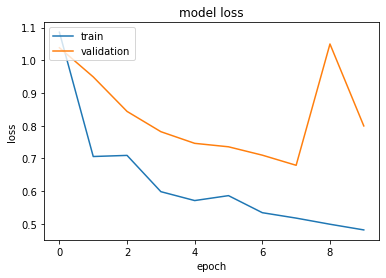

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(test)
print(loss, acc)

16/16 [==============================] - 7s 393ms/step - loss: 0.8528 - accuracy: 0.5595
0.8527803421020508 0.5595238208770752


##Prediction

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model

def get_category(predicted):
    return os.listdir(data_dir+'test/')[np.argmax(predicted)]

image_me = load_img(data_dir + 'test/other/profile.jpg', target_size=(299, 299))

img = (np.array(image_me) / 255.0).reshape(1, 299, 299, 3)
pred = model.predict(img)
label = get_category(pred)
plt.xlabel(label)
plt.imshow(image_me)

##Data augmentation

In [ ]:
#Generating 100 images from single data image
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

img = load_img(data_dir+'train/other/profile.jpeg')
x = img_to_array(img)
x = x.reshape((1,)+x.shape)
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir=data_dir+'train/other', save_prefix='other', save_format='jpg'):
    i += 1
    if i > 100:
        break 